In [1]:
import numpy as np
import math
import  re
import time
from sklearn.model_selection import KFold
from scipy.sparse import csr_matrix, hstack
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
import time
import math
from tqdm import tqdm_notebook 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

Функция *foo_Y_v(...)* возвращает $$ \sum_{i=1}^{n} \sum_{j=i+ 1}^{n} (v_i, v_j) x_i x_j $$
 
 
$$S = \sum_{j=1}^n v_{j,f} x_j$$

In [2]:
def foo_Y_v(X,S,V):
    Sum = S.power(2).sum(axis = 1) - (X.power(2)*V.power(2)).sum(axis = 1) #((X.power(2))*V[:,f])
    return Sum

def foo_S(S,X,V):
    for f in range(k):
        S[:,f] = (X * V[:,f])  
    return S



# Градиенты

In [3]:

def grad_descent_W(X,dy, W, lyambda): 
    Wnew = W  + 2* lyambda * (X.T*dy) / X.shape[0] #np.dot(X.T,dy)/N
    return Wnew

# gradient for V[:,f], v - column V[:,f] 
def gradient_V (X,v,S):
    
    grad = X.multiply(S) - (X.power(2)).multiply(v.T) #S - vector S[:,f], v - vector
    return grad
    
def grad_descent_V(X, dy,V, S, lyambda):
    #print('1',V[:,f].shape, (g))
    Vnew = V + 2 * lyambda * (gradient_V(X, V, S).T*dy) /nfeat  
    #print(Vnew.shape) 
    return Vnew


# RMSE, $R^2$

In [4]:
def foo_RMSE(Yt, Ypr):
    dy = Yt-Ypr
    s = np.power(dy,2).sum()
    rmse = math.sqrt( s  / Yt.shape[0] )
    return rmse


def foo_R2(Yt,Ypr):
    Ey = Yt.mean()
    r2 = 1 - np.sum(np.power(Ypr-Yt,2)) / np.sum(np.power((Yt - Ey),2))
    return r2

# Данные

In [57]:
NumberCustomers = 480189
NumberMovies = 17770 
f = open('combined_data_1.txt','r')
d = dict()
n = -1 # col' number  (X' number of line)
value = -1 #new CustomerID
row = []
col = []
ratings = []
date = []
start = time.time()

for line in tqdm_notebook(f):
    
    result = re.match(r'\d+:',line)
    if result is not None:
        MovieID = int(re.match(r'\d+',result.group(0)).group(0))       
    else:
        if MovieID==5000:
            break
        SplitLine= re.split(r',',line,maxsplit=2)
        KeyCustomerID = int(SplitLine[0])
        if KeyCustomerID in d:
            #search value by key
            CustomerID = d[KeyCustomerID]     
        else:
            #add (key, value)
            value+=1
            d.update([(KeyCustomerID,value)])
            CustomerID = value    
        Rating = int(SplitLine[1])
        Date = SplitLine[2]
        n+=1
        row.append(CustomerID)
        col.append(n)
        row.append(NumberCustomers + MovieID)
        col.append(n)
        ratings.append(Rating)
        date.append(Date)
        



A Jupyter Widget

Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\Nuts\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Nuts\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Nuts\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [58]:
data = np.ones([len(row)])
X = coo_matrix((data, (np.array(col), np.array(row))),dtype=np.int8) 
Y = csr_matrix(np.array(ratings).reshape(X.shape[0],1))
Y = Y.todense()

end = time.time()
print( 'Time: ', (end - start))

Time:  2965.103371858597


In [59]:
del d
del col
del row
del data

X

<24053764x484689 sparse matrix of type '<class 'numpy.int8'>'
	with 48107528 stored elements in COOrdinate format>

indexes - отсортированные по дате индексы строк

In [60]:
X = X.tocsr()

In [61]:
print("create indexes")
indexes = np.argsort(date)

print("create train/test indx")
test_size = 500000
train_indexes = indexes[:-test_size]
test_indexes = indexes[-test_size+1:]

train_indexes = shuffle(train_indexes)

#split train / test
print("create train/test set")
Xtrain = X[train_indexes]
Ytrain = Y[train_indexes]
Xtest = X[test_indexes]
Ytest = Y[test_indexes]

create indexes
create train/test indx
create train/test set


In [62]:
del date

# Инициализация

In [77]:
Stage = 8 # 
batch_size = 400
k = 2

train_size = Xtrain.shape[0]

lyambda_W = 2e-2
lyambda_V = 1e-3
nfeat = X.shape[1]


cost = []
RMSEtrain = []
RMSEtest = []
R2train = []
R2test = []
time_list=[]

 W, V

In [78]:
start = time.time()
#X = X.tocsr()
W = csr_matrix(np.ones(nfeat).reshape(nfeat,1)) 
V = csr_matrix(np.ones((nfeat,k)))
S = lil_matrix(np.ones((batch_size,k)))# lil
Vnew = V.copy()

end = time.time()
print("Total time: ", time.time()-start)

Total time:  0.2872624397277832


# Обучение

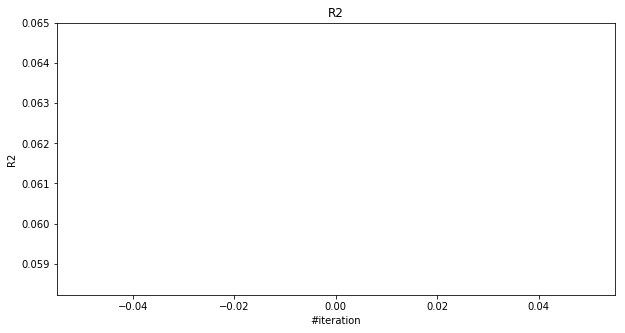

R2test: 0.061613


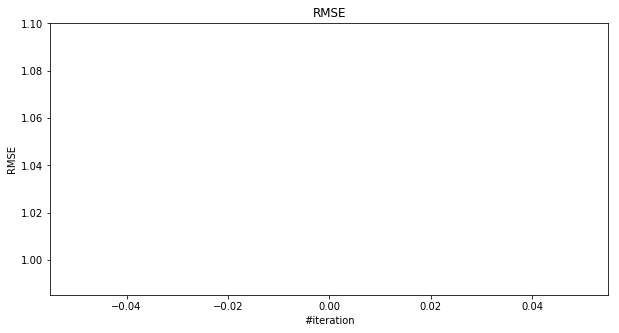

RMSE2test: 1.042779
Time: 20468.458488
Stage №  1 



A Jupyter Widget

KeyboardInterrupt: 

In [79]:
shuffle_indexes = np.arange( Xtrain.shape[0])

start = time.time()
for stage in tqdm_notebook(range(Stage)):
    print('Stage № ', stage, "\n" )
    start_stage = time.time()
    
    for i in tqdm_notebook(range(train_size//batch_size)):
        Xbatch = Xtrain[i*batch_size:(i+1)*batch_size]
        Ybatch = Ytrain[i*batch_size:(i+1)*batch_size]
            
        S = foo_S(S,Xbatch,V)
        Ypred = Xbatch@W + 1/2 * foo_Y_v(Xbatch, S,V)#
        dy = Ybatch - Ypred
        Wnew = grad_descent_W(Xbatch,dy, W, lyambda_W) #
            
        for f in range(k):
                Vnew[:,f] = grad_descent_V( Xbatch, dy,V[:,f], S[:,f],lyambda_V)
         
        W = Wnew
        V = Vnew
    
    #перетасовка строк
    shuffle_indexes = shuffle(shuffle_indexes)
    Xtrain = Xtrain[shuffle_indexes]
    Ytrain = Ytrain[shuffle_indexes]

        
    #Ypred = Xtrain@W + 1/2 * foo_Y_v(Xtrain, foo_S(S,Xtrain,V),V,train_size)
    #cost.append((np.power(dy,2).sum())/train_size)
     
    #rmse = foo_RMSE(Ytrain,Ypred)
    #RMSEtrain.append(rmse)
    #print ("RMSE for train: ",rmse) 
        
    #r2 = foo_R2(Ytrain,Ypred)
    #R2train.append(r2)
    #print("R2 for train: ",r2 , "\n")
        
     #for test   
    Stest = lil_matrix(np.ones((Xtest.shape[0],k)))
    Stest = foo_S(Stest,Xtest,V)
    Ypred_test = Xtest*W + 1/2 * foo_Y_v(Xtest, Stest,V)
        
    rmse = foo_RMSE(Ytest,Ypred_test)
    RMSEtest.append(rmse)
    #print ("RMSE for test: ",rmse ) 
        
    r2 = foo_R2(Ytest,Ypred_test)
    R2test.append(r2)
    #print("R2 for test: ",r2,"\n")
    
    end = time.time()
    time_list.append(end - start_stage)
    #print( 'Time: ', (end - start_stage),'\n')
    
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.title("R2")
    plt.xlabel("#iteration")
    plt.ylabel("R2")
    #plt.plot( R2train, 'b',label="train")
    plt.plot( R2test, 'g',label="test")
    plt.show()
    
    print('R2test: %f' % r2)
    
    plt.figure(figsize=(10, 5))
    plt.title("RMSE")
    plt.xlabel("#iteration")
    plt.ylabel("RMSE")
    #plt.plot(RMSEtrain, 'b', label='train')
    plt.plot(RMSEtest, 'g', label = 'test')
    #plt.plot(cost,'b')
    plt.show()
    print('RMSE2test: %f' % rmse)

    print('Time: %f' % (time.time() - start_stage))
    
print("Total time: ", time.time()-start)

# Результаты


После одного полного прохода тренировочного множества 

In [84]:
print("rmse = ", rmse, "\n ","r2 = ", r2)

rmse =  1.0427788183865119 
  r2 =  0.0616127638623
